# Imports

In [1]:
!pip install catboost -q
!pip install lightgbm -q
!pip install xgboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 8.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# база
import pandas as pd
from catboost  import CatBoostClassifier
import random
import numpy as np

# визуализация
import seaborn as sns
import matplotlib.pyplot as plt

# sklearn
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight

# catboost
from catboost import CatBoostClassifier, Pool
from catboost.utils import get_confusion_matrix

# lightgbm
from lightgbm import Dataset
from lightgbm import LGBMClassifier, train

# xgboost
import xgboost as xgb

# балансирова
from imblearn.under_sampling import NearMiss


In [4]:
random.seed(42)

# Loading data

In [5]:
!cp /content/drive/MyDrive/TGT/train.csv .
!cp /content/drive/MyDrive/TGT/test.csv .

In [6]:
data = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

# Data exploring

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3792 entries, 0 to 3791
Columns: 301 entries, data_1 to label
dtypes: float64(300), int64(1)
memory usage: 8.7 MB


In [9]:
data.head()

,data_1,data_2,data_3,data_4,data_5,data_6,data_7,data_8,data_9,data_10,...,data_292,data_293,data_294,data_295,data_296,data_297,data_298,data_299,data_300,label
0,-0.266033,-0.496437,-0.572447,-0.220903,0.266033,0.643705,0.365796,0.375297,0.014252,-0.527316,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,0.125475,-0.007605,-0.030418,0.285171,0.574144,0.418251,0.304183,0.277567,0.433460,0.231939,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,0.130435,0.445652,0.358696,0.086957,-0.076087,0.173913,0.173913,0.304348,0.141304,0.304348,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,0.032628,-0.019400,0.033510,-0.009700,0.037919,-0.014109,0.008818,-0.005291,0.027337,-0.037919,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,0.006105,0.005723,0.004197,-0.001145,-0.009538,-0.009538,-0.000382,-0.006868,-0.006105,-0.012591,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


***ПОСМОТРИМ НА СПЕКТОГРАММЫ***

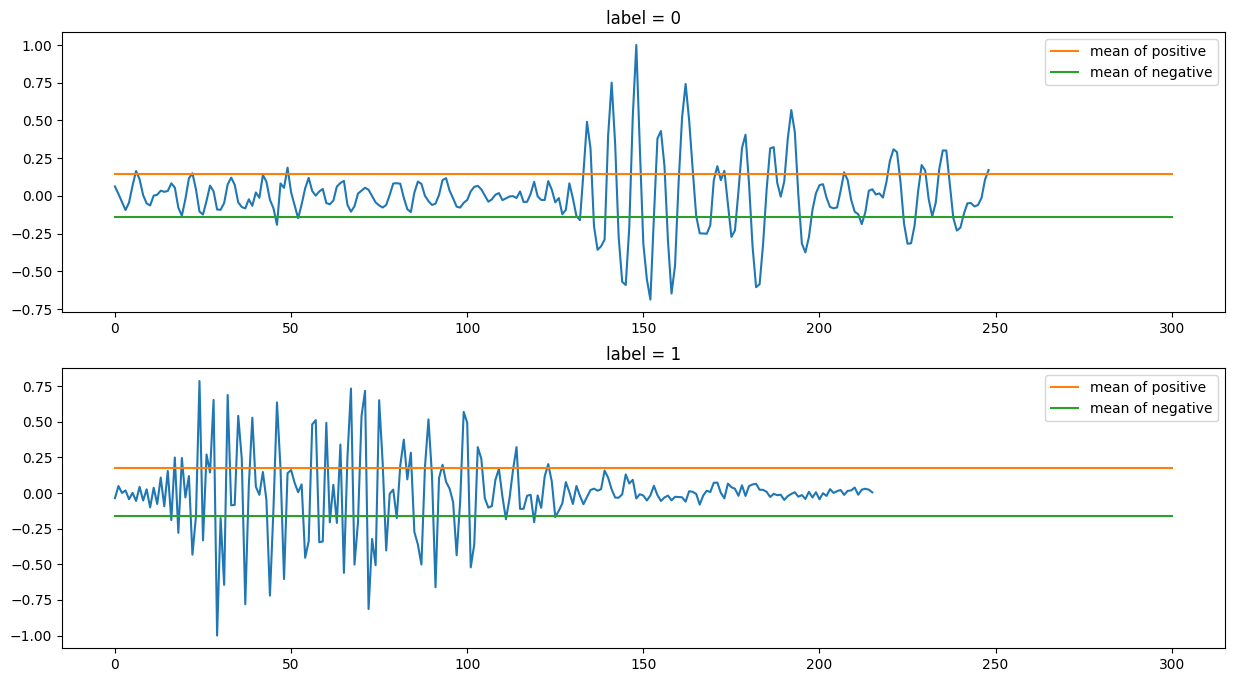

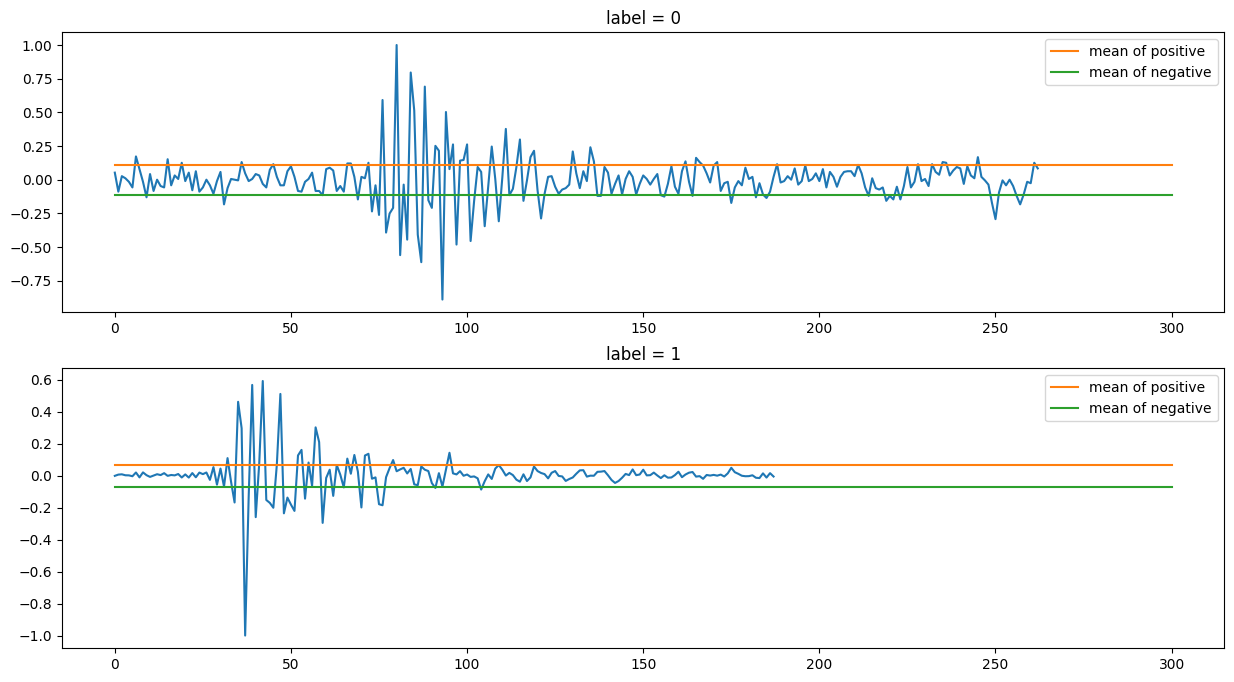

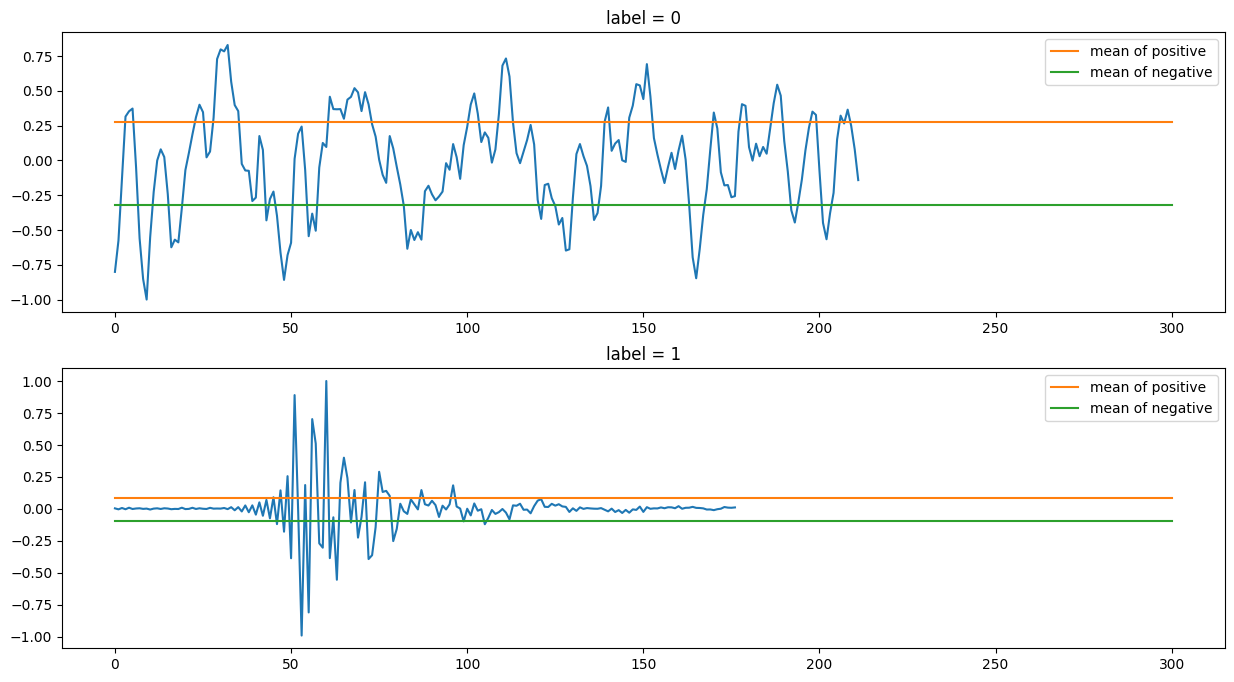

In [ ]:
def show_spectrogram(n_samples):
    label_0_list = (data[data['label'] == 0].drop('label', axis=1).index.values)
    label_1_list = (data[data['label'] == 1].drop('label', axis=1).index.values)

    label_0_index = random.sample(range(0, len(label_0_list)), n_samples)
    label_1_index = random.sample(range(0, len(label_1_list)), n_samples)


    for i in range(n_samples):

        i_0 = label_0_index[i]
        index_0 = label_0_list[i_0]

        i_1 = label_1_index[i]
        index_1 = label_1_list[i_1]

        fig, ax = plt.subplots(2, figsize=(15, 8))
        

        ax[0].plot(data.drop('label', axis=1).iloc[index_0].dropna().values)
        ax[0].plot([0, 300], [data[data > 0].iloc[index_0].mean(), data[data > 0].iloc[index_0].mean()], label='mean of positive')
        ax[0].plot([0, 300], [data[data < 0].iloc[index_0].mean(), data[data < 0].iloc[index_0].mean()], label='mean of negative')
        ax[0].set_title('label = 0')
        ax[0].legend()

        ax[1].plot(data.drop('label', axis=1).iloc[index_1].dropna().values)
        ax[1].plot([0, 300], [data[data > 0].iloc[index_1].mean(), data[data > 0].iloc[index_1].mean()], label='mean of positive')
        ax[1].plot([0, 300], [data[data < 0].iloc[index_1].mean(), data[data < 0].iloc[index_1].mean()], label='mean of negative')
        ax[1].set_title('label = 1')
        ax[1].legend()

        plt.show()


show_spectrogram(n_samples=3)

**Вывод**

---




*   Класс 0 представляет собой всевозможные сигналы, в основном ***равномерные***
*   У 1 класса наблюдается **резкое увелечение громкости** звука (в оносном **в начале**), в остальное же время звук чаще чего тихий, а также нет перепадов



***ПОСМОТРИМ НА РАСПРЕДЕЛЕНИЕ КЛАССОВ***


<Axes: xlabel='label', ylabel='Count'>

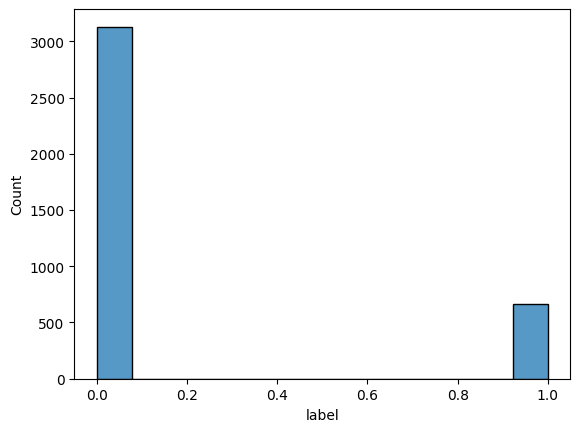

In [ ]:
sns.histplot(data=data,
             x='label',
             )

---
**Ясно видел дизбаланс классов**


# Feature Engineering

In [ ]:
first_columns = list(data.drop('label', axis=1).columns)

## Фичи, которые помогают

**Количество непропущенных**

In [ ]:
data['not_nan'] = data[first_columns].notna().sum(axis=1)
data_test['not_nan'] = data_test[first_columns].notna().sum(axis=1)


**Средняя позиция тех, что больше среднего**

In [ ]:
def normalized_mean_position(data):
    now = np.absolute(data[first_columns])
    now['mean'] = now.mean(axis=1)
    #now[now == now['mean']]
    values = []
    l = []
    l_1 = []
    l_2 = []
    for i in range(len(data)):
        values.append(sum(now.iloc[i].values > now.iloc[i]['mean']) / data.iloc[i]['not_nan'])
        a = now[now > now.iloc[i]['mean']][first_columns].iloc[i].notna()
        try:
            l.append((int(a[a == True].keys()[-1].split('_')[-1]) - int(a[a == True].keys()[0].split('_')[-1])) / data.iloc[i]['not_nan'] )
            l_1.append(int(a[a == True].keys()[0].split('_')[-1]) /  data.iloc[i]['not_nan'])
            l_2.append(int(a[a == True].keys()[-1].split('_')[-1]) / data.iloc[i]['not_nan'])
        except:
            l.append(0)
            l_1.append(0)
            l_2.append(0)

    data['first l'] = l
    data['first l_1'] = l_1
    data['first l_2'] = l_2

    return data

data = normalized_mean_position(data)
data_test = normalized_mean_position(data_test)

**Среднеквадратичное отклонение**

<Axes: xlabel='std', ylabel='Count'>

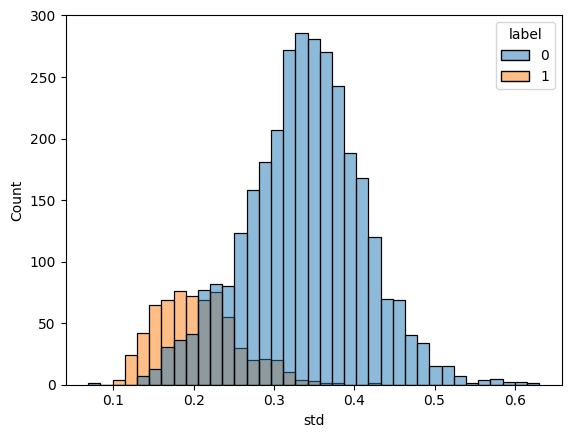

In [ ]:
data['std'] = data[first_columns].std(axis=1)
data_test['std'] = data[first_columns].std(axis=1)

sns.histplot(data=data,
             x='std',
             hue='label',
             kde=True)

**Cреднее значение по строке**

In [ ]:
data['mean_before_fillna'] = data[first_columns].mean(axis=1)
data['median_before_fillna'] = data[first_columns].median(axis=1)
data_test['mean_before_fillna'] = data_test[first_columns].mean(axis=1)
data_test['median_before_fillna'] = data_test[first_columns].median(axis=1)

In [ ]:
hist_mean = data.groupby('label', as_index=False)[['mean_before_fillna', 'median_before_fillna']].mean()

In [ ]:
hist_mean

,label,mean_before_fillna,median_before_fillna
0,0,0.031450,0.031721
1,1,0.008328,0.007888


**Нормированное (кол-во > среднего)**

In [ ]:
def norm_more_mean_count(data): 
    now = np.absolute(data[first_columns])
    now['mean'] = now.mean(axis=1)
    #now[now == now['mean']]
    values = []
    for i in range(len(data)):
        values.append(sum(now.iloc[i].values > now.iloc[i]['mean']) / data.iloc[i]['not_nan'])

    data['main'] = values
    return data

data = norm_more_mean_count(data)
data_test = norm_more_mean_count(data_test)

<Axes: xlabel='main', ylabel='Count'>

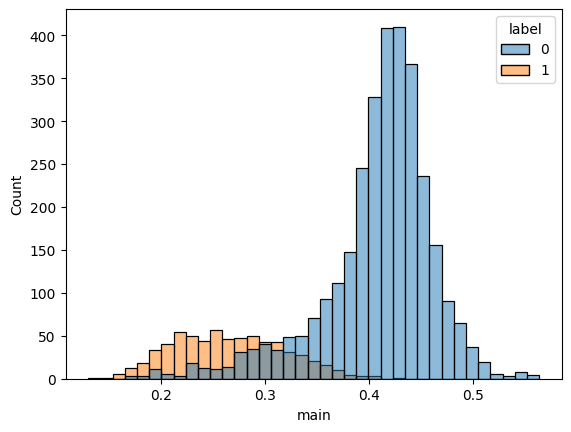

In [ ]:
sns.histplot(data=data,
             x='main',
             hue='label',
             kde=True)

**Отнормированная разница индексов между ближайшими по значению порога**

---

А также отнормированное первое и последнее вхождение (по индексу)



In [ ]:

def treshold_norm(data, tresholds):
    for treshold in tresholds:
        l = []
        l_1 = []
        l_2 = []
        for i in range(len(data)):
            a = data[data > treshold][first_columns].iloc[i].notna()
            try:
                l.append((int(a[a == True].keys()[-1].split('_')[-1]) - int(a[a == True].keys()[0].split('_')[-1])) / data.iloc[i]['not_nan'] )
                l_1.append(int(a[a == True].keys()[0].split('_')[-1]) /  data.iloc[i]['not_nan'])
                l_2.append(int(a[a == True].keys()[-1].split('_')[-1]) / data.iloc[i]['not_nan'])
            except:
                l.append(0)
                l_1.append(0)
                l_2.append(0)
        data['l ' + str(treshold)] = l
        data['l_1 ' + str(treshold)] = l_1
        data['l_2 ' + str(treshold)] = l_2
    
    return data

# объявим пороги
tresholds = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55,  0.6, 0.65, 0.7, 0.8, 0.9]

# обновим датафреймы
data = treshold_norm(data=data, tresholds=tresholds)
data_test = treshold_norm(data=data_test, tresholds=tresholds)



In [ ]:
data.groupby('label', as_index=False)[['l 0.4', 'l_1 0.4', 'l_2 0.4']].agg(['mean', 'median'])

l 0.4             l_1 0.4             l_2 0.4          
           mean    median      mean    median      mean    median
label                                                            
0      0.742650  0.868815  0.123816  0.056122  0.866467  0.953704
1      0.161003  0.132064  0.244634  0.233784  0.405637  0.373923

**Посмотрим на сумму отрицательных и положительных значений по классам**

In [ ]:
data['negative_sum'] = data[first_columns][(data < 0)].sum(axis=1)
data['positive_sum'] = data[first_columns][(data > 0)].sum(axis=1)
data_test['negative_sum'] = data_test[first_columns][(data < 0)].sum(axis=1)
data_test['positive_sum'] = data_test[first_columns][(data > 0)].sum(axis=1)

data.groupby('label', as_index=False)[['positive_sum', 'negative_sum']].agg(['median', 'mean'])

positive_sum            negative_sum           
            median       mean       median       mean
label                                                
0        23.352857  24.998689   -18.044080 -19.789353
1         9.183290  10.095150    -7.996916  -8.678700

<Axes: xlabel='positive_sum', ylabel='Count'>

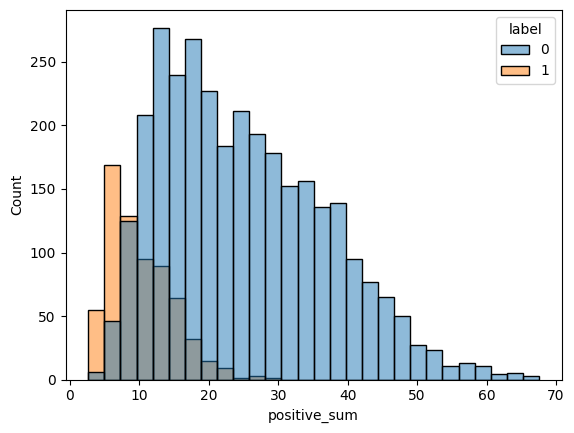

In [ ]:
sns.histplot(data=data,
             x='positive_sum',
             hue='label',
             kde=True)

**Количество отрицательных и положительных по классу**

In [ ]:
data['negative_count'] = data[first_columns][(data < 0)].count(axis=1)
data['positive_count'] = data[first_columns][(data > 0)].count(axis=1)
data_test['negative_count'] = data_test[first_columns][(data_test < 0)].count(axis=1)
data_test['positive_count'] = data_test[first_columns][(data_test > 0)].count(axis=1)

data.groupby('label', as_index=False)[['negative_count', 'positive_count']].agg(['median', 'mean'])

negative_count            positive_count           
              median       mean         median       mean
label                                                    
0               77.0  79.222045           91.0  92.295208
1               74.0  77.090634           89.5  92.657100

**Отношение суммы значений на их количество**

In [ ]:
data['pos_sum/count'] = data['positive_sum'] / data['positive_count']
data['neg_sum/count'] = data['negative_sum'] / data['negative_count']


data_test['pos_sum/count'] = data_test['positive_sum'] / data_test['positive_count']
data_test['neg_sum/count'] = data_test['negative_sum'] / data_test['negative_count']

data.groupby('label', as_index=False)[['pos_sum/count', 'neg_sum/count']].agg(['median', 'mean'])

pos_sum/count           neg_sum/count          
             median      mean        median      mean
label                                                
0          0.285455  0.279344     -0.259418 -0.257741
1          0.108871  0.115311     -0.114716 -0.119268

**Добавим сумму модулей по строке**

In [ ]:
data['module_sum'] = np.absolute(data[first_columns]).sum(axis=1)
data_test['module_sum'] = np.absolute(data_test[first_columns]).sum(axis=1)

data.groupby('label', as_index=False)['module_sum'].agg(['median', 'mean'])

,median,mean
label,,
0,42.226473,44.788042
1,17.293195,18.773850


Кол-во пропущенных

In [ ]:
data['NaN_count'] = data[first_columns].isna().sum(axis=1)
data_test['NaN_count'] = data_test[first_columns].isna().sum(axis=1)

<Axes: xlabel='NaN_count', ylabel='Count'>

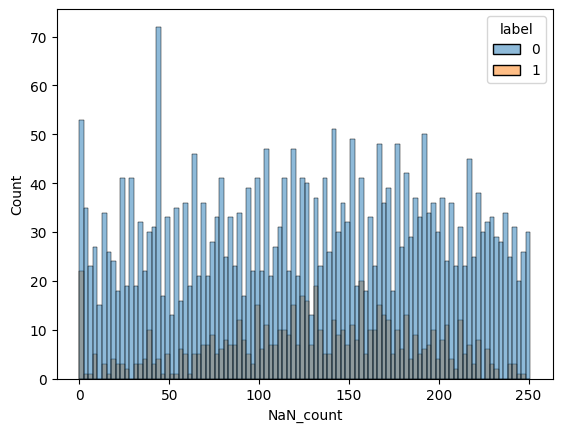

In [ ]:
sns.histplot(data=data,
             x='NaN_count',
             hue='label',
             bins=100)

**Просто сумма**

In [ ]:
data['sum'] = data[first_columns].sum(axis=1)
data_test['sum'] = data_test[first_columns].sum(axis=1)


data_sum = data.groupby('label')['sum'].mean()
data_sum = pd.DataFrame({'label': data_sum.index,
                         'values': data_sum.values})

data_sum['values']

0    5.209337
1    1.416450
Name: values, dtype: float64

**Отношение**

In [ ]:
data['otn_1'] = data['mean_before_fillna'] / data['not_nan']
data_test['otn_1'] = data_test['mean_before_fillna'] / data_test['not_nan']


data['otn_2'] = data['module_sum'] / data['not_nan']
data_test['otn_2'] = data_test['module_sum'] / data_test['not_nan']




data.groupby('label')[['otn_1', 'otn_2']].mean()

,otn_1,otn_2
label,,
0,0.000242,0.268103
1,0.000056,0.115776


## Посмотрим корелляцию добавленных фичей

<Axes: >

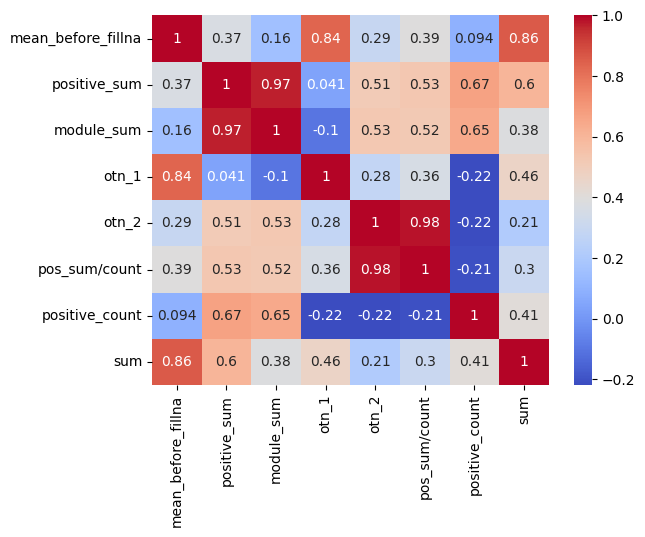

In [ ]:
added_features = ['mean_before_fillna', 'positive_sum', 'module_sum','otn_1', 'otn_2',
                  'pos_sum/count', 'positive_count', 'sum']


sns.heatmap(data[added_features].corr(),
            annot=True,
            cmap='coolwarm')

## Уменьшим размерность до 60

In [ ]:
def demension_to_60(data):

    now = np.absolute(data[first_columns])
    now['mean'] = now.mean(axis=1)

    for i in range(0, 300, 10):
        data[str(i) + '-' + str(i + 10)] = (now[now.columns[i: i + 10]].sum(axis=1))

    not_need_columns = data.columns[:300].values
    data.drop(not_need_columns, axis=1, inplace=True)

    return data


data = demension_to_60(data=data)
data_test = demension_to_60(data=data_test)

In [ ]:
data.head()

,label,not_nan,std,mean_before_fillna,median_before_fillna,main,negative_sum,positive_sum,negative_count,positive_count,...,200-210,210-220,220-230,230-240,240-250,250-260,260-270,270-280,280-290,290-300
0,0,150,0.439014,0.013903,0.036817,0.460000,-25.904988,27.990499,71,79,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,0,204,0.369065,0.018098,-0.001901,0.446078,-29.638783,33.330798,102,102,...,0.262357,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2,0,108,0.317564,0.069444,0.097826,0.416667,-10.608696,18.108696,41,67,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
3,1,139,0.247292,0.005754,0.002646,0.251799,-9.221340,10.021164,66,71,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
4,0,275,0.223418,-0.000398,-0.001145,0.210909,-14.341854,14.232354,144,130,...,0.239985,0.15414,0.120946,0.185044,0.080504,0.071347,0.093476,0.035864,0.0,0.0


# Fillna

По сколько пропущенные - это просто время, когда запись не велась, надо чем-то заполнить

In [ ]:
data.fillna(-10000, inplace=True)
data_test.fillna(-10000, inplace=True)

# Балансировка

Сохраним первоначальный датасет

In [ ]:
# попробовал 0.3
nm = NearMiss(sampling_strategy=0.5)
X_train_miss, Y_train_miss = nm.fit_resample(data.drop('label', axis=1),
                                             data['label'].ravel(),
                                             #sampling_strategy='auto'
                                             )

print('После применения метода кол-во меток со значением 1: {}'.format(sum(Y_train_miss == 1)))
print('После применения метода кол-во меток со значением 0: {}'.format(sum(Y_train_miss == 0)))
Y_train_miss = pd.DataFrame({'label':Y_train_miss})

После применения метода кол-во меток со значением 1: 662
После применения метода кол-во меток со значением 0: 1324


In [ ]:
X_train_miss['label'] = Y_train_miss['label']
data = X_train_miss

<ipython-input-351-15c484c5528a>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_miss['label'] = Y_train_miss['label']


# CatBoost

## Подбререм гиперпараметры

In [ ]:
#train_dataset, eval_dataset = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)

data_for_grid_pool = Pool(data=data.drop('label', axis=1), label=data['label'])
#test_pool = Pool(data=eval_dataset.drop('label', axis=1), label=eval_dataset['label'])

In [ ]:
model = CatBoostClassifier(
                           loss_function='Logloss', # можно попробовать MultiClass
                           eval_metric="F1", # пробовал и custom_metric, не работает
                           #random_seed=42,
                           auto_class_weights='Balanced',
                           boosting_type='Plain',
                           grow_policy='Lossguide', # чтобы регулизировать max_leaves,
                           iterations=3000,
                           early_stopping_rounds=150,
                           task_type='GPU'
                           )

grid = {
        'learning_rate': [0.03, 0.3, 0.1, 0.01],
        'depth': [1, 3, 5],
        'l2_leaf_reg': [3, 5, 7],
        'max_leaves':[2, 3, 5],
        'min_data_in_leaf':[3, 5, 10, 20],


        #'colsample_bylevel ': [],
        #'max_bin': [],
        # эти параметры на гпу не работают
        #'bootstrap_type': ['MVS','Bernoulli'],
        #'subsample':[0.85, 0.75, 0.95],
        }

grid_search_result = model.grid_search(grid,
                                       X=data_for_grid_pool,
                                       cv=3,
                                       stratified=True,
                                       shuffle=True,
                                       verbose=False)


In [ ]:
grid_search_result["params"]

{'max_leaves': 5,
 'min_data_in_leaf': 3,
 'depth': 5,
 'l2_leaf_reg': 7,
 'learning_rate': 0.3}

## Training model, cross-validation

0:	learn: 0.9216800	test: 0.9098201	best: 0.9098201 (0)	total: 3.96ms	remaining: 19.8s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.9483775752
bestIteration = 106

Shrink model to first 107 iterations.
[[999  45]
 [ 13 207]]


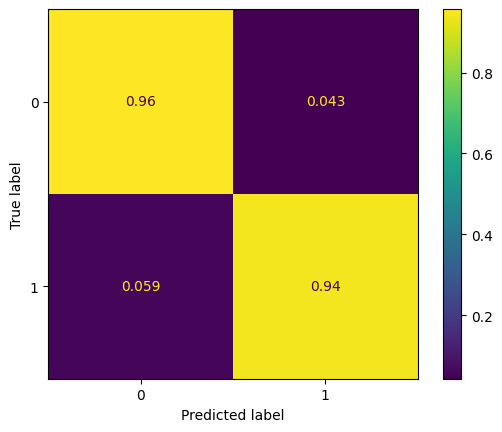

0:	learn: 0.9138490	test: 0.8985296	best: 0.8985296 (0)	total: 5.04ms	remaining: 25.2s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.9414274502
bestIteration = 70

Shrink model to first 71 iterations.
[[998  45]
 [ 16 205]]


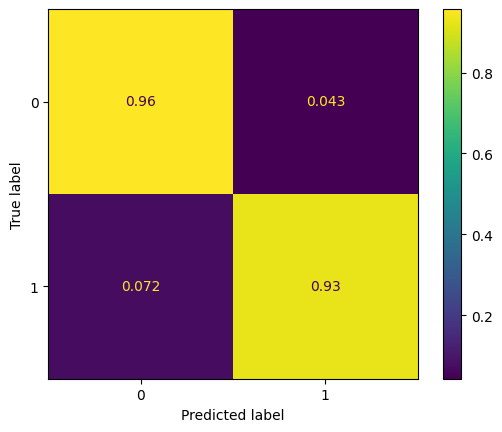

0:	learn: 0.9129958	test: 0.9220117	best: 0.9220117 (0)	total: 8.42ms	remaining: 42.1s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.9623559944
bestIteration = 45

Shrink model to first 46 iterations.
[[1002   41]
 [   8  213]]


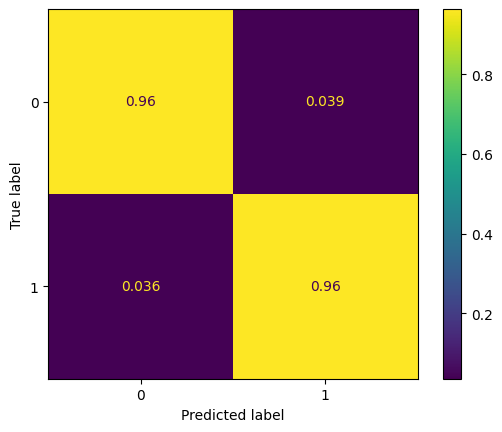

mean F1 score ---------> 0.9507 +- 0.00874


In [ ]:
n_splits = 3 # Число фолдов. Оптимально 3, 5 или 10
catboost_clfs = [] # Тут будем сохранять модели
scores = [] # Тут будем хранить скоры валидационных фолдов

# ТАК БЫЛО ДО БАЛАНСИРОВКИ
# параметры валидации, обучение будет идти на n_splits фолдах
X = data.drop('label', axis=1)
y = data["label"]



kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
for train_index, test_index in kf.split(X, y):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Специальный класс для ускорения обучения 
    train_dataset = Pool(data=X_train, label=y_train)
    eval_dataset = Pool(data=X_test, label=y_test)

    clf = CatBoostClassifier(
        n_estimators=5000,
        early_stopping_rounds=300,

        learning_rate=0.3,
        loss_function='Logloss', # можно попробовать MultiClass
        grow_policy='Lossguide', # чтобы регулизировать max_leaves,

        #custom_metric=["F1"], # выводит метрику с use weights и no use weights
        # вроде по ней, а не по кастомной он если что делает early stopping
        eval_metric="F1", #  выводит то же, что и custom metric, но только с use weights

        
        max_leaves=5,
        min_data_in_leaf=3,
        boosting_type='Plain', # ordered - маленькие датасеты, учится дольше,  качество лучше
        depth=3,
        l2_leaf_reg=7,
        subsample=0.8,
        bootstrap_type= 'MVS', # ошибка на gpu
        # не делает квантизацию для gold feature (как я понял). Можно поиграться со значением, либо добавить еще второй
        #per_float_feature_quantization='301:border_count=5000',
        
        #ignored_features=not_need_columns,
        auto_class_weights='Balanced',
        #class_weights=[2.5, 1], # проставить веса классов вручную

        border_count=254, # чтобы на CPU и GPU был одинаковый скор
        random_seed=42,
        
        task_type='CPU'
    )

    clf.fit(
        train_dataset,
        eval_set=eval_dataset,
        use_best_model=True,
        verbose=1000,
        plot=False)
    
    catboost_clfs.append(clf)




    # Not normalized confusion matrix
    print(confusion_matrix(y_test, clf.predict(X_test)))

    # Normalized confusion matrix
    cm = confusion_matrix(y_test,
                          clf.predict(X_test),
                          normalize='true',
                          labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()
    plt.show()

    scores.append(np.mean([v for k, v in clf.best_score_["validation"].items() if "F1" in k], dtype="float16"))
    # scores.append(clf.best_score_['validation']['MultiClass'])
    # clf.save_model("../tmp_data/cool_catboost_model_{}_deep".format(n))

assert len(catboost_clfs) == n_splits
print("mean F1 score --------->", np.mean(scores, dtype="float16"), "+-", np.std(scores, dtype="float16"))

## Смотрим скор

In [ ]:
print(scores, '\n', 
      np.mean(scores, dtype="float16") - np.std(scores, dtype="float16"), '\n',
      np.mean(scores, dtype="float16"), '+-', np.std(scores, dtype="float16")
)

[0.9473, 0.9473, 0.9604] 
 0.9453 
 0.9517 +- 0.006214


In [ ]:
for clf in catboost_clfs:
  print(clf.best_score_)

{'learn': {'Logloss': 0.007990463147799222, 'F1': 1.0}, 'validation': {'Logloss': 0.1392283017926091, 'F1': 0.9471117647228071}}
{'learn': {'Logloss': 0.008221679361145887, 'F1': 1.0}, 'validation': {'Logloss': 0.1525341113792889, 'F1': 0.947417577602377}}
{'learn': {'Logloss': 0.008454957983891006, 'F1': 1.0}, 'validation': {'Logloss': 0.12032720967442548, 'F1': 0.9606320782925708}}


## Какие гиперпараметры он подобрал

In [ ]:
need_params = [
  "boosting_type","boosting_type","max_ctr_complexity","leaf_estimation_iterations", "rsm","one_hot_max_size",
    "subsample", "depth","task_type","eval_metric","n_estimators", "loss_function","min_data_in_leaf",
    "learning_rate", "auto_class_weights","classes_count", "random_seed","l2_leaf_reg", 'n_estimators', 'max_bin', 'class_weights'
]

for key, value in catboost_clfs[np.random.randint(0, 2)].get_all_params().items():
    if key in need_params:
        print("{}, {}".format(key, value))

eval_metric, F1
boosting_type, Plain
l2_leaf_reg, 7
rsm, 1
subsample, 0.800000011920929
random_seed, 42
depth, 3
class_weights, [1, 4.719457149505615]
classes_count, 0
auto_class_weights, Balanced
min_data_in_leaf, 3
loss_function, Logloss
learning_rate, 0.30000001192092896
task_type, CPU
leaf_estimation_iterations, 10


## Catboost Feature Importance

In [ ]:
importance = catboost_clfs[0].get_feature_importance(prettified=True)

importance[importance['Importances'] != 0].head(10)

,Feature Id,Importances
0,0-10,42.108595
1,pos_sum/count,16.606487
2,main,13.226176
3,10-20,4.934489
4,sum,2.153528
5,otn_2,2.125239
6,negative_sum,1.689823
7,20-30,1.567312
8,170-180,1.363127
9,neg_sum/count,1.252806


**Добавленные фичи в топе**

# LightGBM

## Training model, cross-validation

In [ ]:
n_splits = 3  # Число фолдов. Оптимально 3, 5 или 10
lightgbm_clfs = [] # Тут будем сохранять модели
scores = [] # Тут будем хранить скоры валидационных фолдов

# ТАК БЫЛО ДО БАЛАНСИРОВКИ
# параметры валидации, обучение будет идти на n_splits фолдах
X = data.drop('label', axis=1)
y = data["label"]



kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
for train_index, test_index in kf.split(X, y):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        
    clf = LGBMClassifier(
            objective='binary',
            #metric='f1',
            class_weight='balanced',
            n_estimators=1000,
            
            boosting_type='dart',

            #num_leaves=3,
            #reg_alpha=1
    )

    clf.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="f1",
            callbacks=[
                    #lgb.reset_parameter(learning_rate=np.linspace(0.1, 1, 1000).tolist()),
                    lgb.early_stopping(stopping_rounds=200)
            ]
    )

    
    
    lightgbm_clfs.append(clf)


    # Not normalized confusion matrix
    print(confusion_matrix(y_test, clf.predict(X_test)))

    # Normalized confusion matrix
    cm = confusion_matrix(y_test,
                          clf.predict(X_test),
                          normalize='true',
                          labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot(colorbar=False)
    plt.show()

    preds = clf.predict(X_test)
    score = f1_score(y_test, preds)
    scores.append(score)
    print('Validation F1:', score)
    # scores.append(clf.best_score_['validation']['MultiClass'])
    # clf.save_model("../tmp_data/cool_catboost_model_{}_deep".format(n))

assert len(lightgbm_clfs) == n_splits
print("mean F1 score --------->", np.mean(scores, dtype="float16"), "+-", np.std(scores, dtype="float16"))

## Смотрим скор

In [ ]:
print(scores, '\n', np.mean(scores))

[0.9185185185185184, 0.9213483146067416, 0.9077490774907749, 0.8985507246376813, 0.917910447761194] 
 0.9128154166029822


# XGBoost

## Grid search

## Training model, cross-validation

In [ ]:
from sklearn.utils import class_weight

In [ ]:
n_splits = 3  # Число фолдов. Оптимально 3, 5 или 10
xgboost_clfs = [] # Тут будем сохранять модели
scores = [] # Тут будем хранить скоры валидационных фолдов

# ТАК БЫЛО ДО БАЛАНСИРОВКИ
# параметры валидации, обучение будет идти на n_splits фолдах
X = data.drop('label', axis=1)
y = data["label"]

# веса для балансировки классов
classes_weights = class_weight.compute_sample_weight(
        class_weight='balanced',
        y=data['label']
) 

kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1488)
for train_index, test_index in kf.split(X, y):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    dtrain = xgb.DMatrix(X_train, label=y_train, nthread=-1)
    dtest = xgb.DMatrix(X_test, y_test, nthread=-1)
 
    
    clf = xgb.XGBClassifier(
                        learning_rate=0.1,
                        objective='binary:logistic',
                        subsample=0.8,
                        eval_metric='auc',
                        max_depth=2,
                        #min_child_weight=5,
                        n_estimators=10000,

                        # Возможно не работает, потому что чет особо не помогает
                        classes_weights=classes_weights
                        )

    clf.fit(X_train,
            y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            early_stopping_rounds=100)    
    
    xgboost_clfs.append(clf)


    # Not normalized confusion matrix
    print(confusion_matrix(y_test, clf.predict(X_test)))

    # Normalized confusion matrix
    cm = confusion_matrix(y_test,
                          clf.predict(X_test),
                          normalize='true',
                          labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot(colorbar=False)
    plt.show()

    preds = clf.predict(X_test)
    score = f1_score(y_test, preds)
    scores.append(score)
    print('Validation F1:', score)
    # scores.append(clf.best_score_['validation']['MultiClass'])
    # clf.save_model("../tmp_data/cool_catboost_model_{}_deep".format(n))

assert len(xgboost_clfs) == n_splits
print("mean F1 score --------->", np.mean(scores, dtype="float16"), "+-", np.std(scores, dtype="float16"))

## Ссмотрм скор

In [ ]:
print(scores, '\n', 
      np.mean(scores, dtype="float16") - np.std(scores, dtype="float16"), '\n',
      np.mean(scores, dtype="float16"), '+-', np.std(scores, dtype="float16")
)

[0.8894009216589862, 0.881578947368421, 0.9026548672566371] 
 0.8823 
 0.891 +- 0.0087


# Predict на первоначальной дате 

(просто ради интереса)

In [ ]:
predict = np.zeros((data.shape[0], data['label'].nunique()))
for clf in catboost_clfs:
    predict += clf.predict_proba(data.drop('label', axis=1))

predict = predict.argmax(axis=1)

print('Еденичек:', sum(predict == 1), '\nНоликов:', sum(predict == 0))



Еденичек: 748 
Ноликов: 3044


In [ ]:
f1_score(data['label'], predict)

0.9333333333333333

In [ ]:
print(classification_report(data['label'], predict))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3130
           1       0.94      0.96      0.95       662

    accuracy                           0.98      3792
   macro avg       0.97      0.97      0.97      3792
weighted avg       0.98      0.98      0.98      3792



# Predict & Blending

**Catboost**

In [ ]:
catboost_predict = np.zeros((data_test.shape[0], data['label'].nunique()))
for clf in catboost_clfs:
    catboost_predict += clf.predict_proba(data_test)
    
catboost_predict = list(map(lambda x: x / 3, catboost_predict))

**XGBoost**

In [ ]:
xgboost_predict = np.zeros((data_test.shape[0], data['label'].nunique()))
for clf in xgboost_clfs:
    xgboost_predict += clf.predict_proba(data_test)

xgboost_predict = list(map(lambda x: x / 3, xgboost_predict))

**Blending**

In [ ]:
# веса классификаторов
catboost_weight = 0.6
xgboost_weight = 0.4

catboost_predict_weighted = list(map(lambda x: x * catboost_weight, catboost_predict))
xgboost_predict_weighted = list(map(lambda x: x * xgboost_weight, xgboost_predict))

# делаем ансамбль
ensemble = np.zeros((data_test.shape[0], data['label'].nunique()))
for i in range(len(catboost_predict_weighted)):
    first_class_probability = catboost_predict_weighted[i][0] + xgboost_predict_weighted[i][0]
    second_class_probability = catboost_predict_weighted[i][1] + xgboost_predict_weighted[i][1]

    ensemble[i][0] += first_class_probability
    ensemble[i][1] += second_class_probability

# выбираем класс
ensemble = list(map(lambda x: clf.classes_[x], ensemble.argmax(axis=1)))
ensemble = pd.DataFrame({'label': ensemble})

In [ ]:
print('Еденичек:', sum(ensemble['label'] == 1), '\nНоликов:', sum(ensemble['label'] == 0))

Еденичек: 232 
Ноликов: 218


# Save submission

In [ ]:
answer = ensemble
answer.to_csv('TGT.csv', index=False)